# Assignment: Decision Trees and Random Forests

## Business Understanding

The objectives of this assignment are:
- to learn to use decision trees to build a transparent, human-readable predictive model.
- to learn to use random forests for improved predictive performance.

Task:
- Our goal is to figure out if we can build a model that can accurately classify websites as either phishing or legitimate based on easily obtainable features.

Plan:
- We will start with importing the libraries and fetching the dataset. Then we will study the data to understand its structure and characteristics. After that, we will prepare the data for modeling. In the modeling stage we will create a decision tree and a random forest model. Finally, we will evaluate the models' performance and discuss deployment options.


In [103]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# fetch dataset 
phishing_websites = fetch_ucirepo(id=327) 
data = phishing_websites.data.original



##  Data Understanding

Before we start to go through the data we can make a statement that this dataset does not contain any missing values and even though the documentation is poor, all features seem to be categorical and logical to some extent.


In [91]:
data.head()

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


The dataset consist of multiple features extracted from website URLSs and their associated metadata. These features describe characteristics commonly used to indentify phishing websites, such as the presence of IP addresses in URLS, abnormal URL lengths, usage of URL shortening services, and SSL certificate properties.

Each features takes discrete values (-1, 0, 1), representing phishing, suspicious, or legitimate behavior respectively.

The target variable 'result' indicates whether a website is phishing (-1) or legitimate (1).

The variables and their possible values are as follows:
- having_ip_Address             (1, -1)
- url_Length                    (1, 0, -1)
- Shortining_service            (1, -1)
- having_at_Symbol              (1, -1)
- double_slash_redirecting      (1, -1)
- prefix_suffix                 (1, -1)
- having_sub_domain             (1, 0, -1)
- sslfinal_state                (1, 0, -1)
- domain_registration_length    (1, -1)
- favicon                       (1, -1)
- port                          (1, -1)
- https_token                   (1, -1)
- request_url                   (1, -1)
- url_of_anchor                 (1, 0, -1)
- links_in_tags                 (1, 0, -1)
- sfh                           (1, 0, -1)
- submitting_to_email           (1, -1)
- abnormal_url                  (1, -1)
- redirect                      (1, 0)
- on_mouseover                  (1, -1)
- rightclick                    (1, -1)
- popupwindow                   (1, -1)
- iframe                        (1, -1)
- age_of_domain                 (1, -1)
- dnsrecord                     (1, -1)
- web_traffic                   (1, 0, -1
- page_rank                     (1, -1)
- google_index                  (1, -1)
- links_pointing_to_page        (1, 0, -1)
- statistical_report            (1, -1)
- result                        (1, -1)

Documentation for the dataset is terrible, but in the original documentation it is said that for the target variable "result", 1 means legitimate and -1 means phishing. For the features we decided to assume that 1 means good and -1 means bad. Some features have also a neutral value of 0.

Lets see the distribution of the target variable "result" to understand how many phishing and legitimate websites are in the dataset.


In [92]:
legitimate_count = data[data['result'] == 1].shape[0]
phishing_count = data[data['result'] == -1].shape[0]
print(f'Legitimate websites: {legitimate_count}')
print(f'Phishing websites: {phishing_count}')

Legitimate websites: 6157
Phishing websites: 4898


To visualize the data distribution between classes, we can create histograms for each feature, layering the phishing and legitimate website data on top of each other.


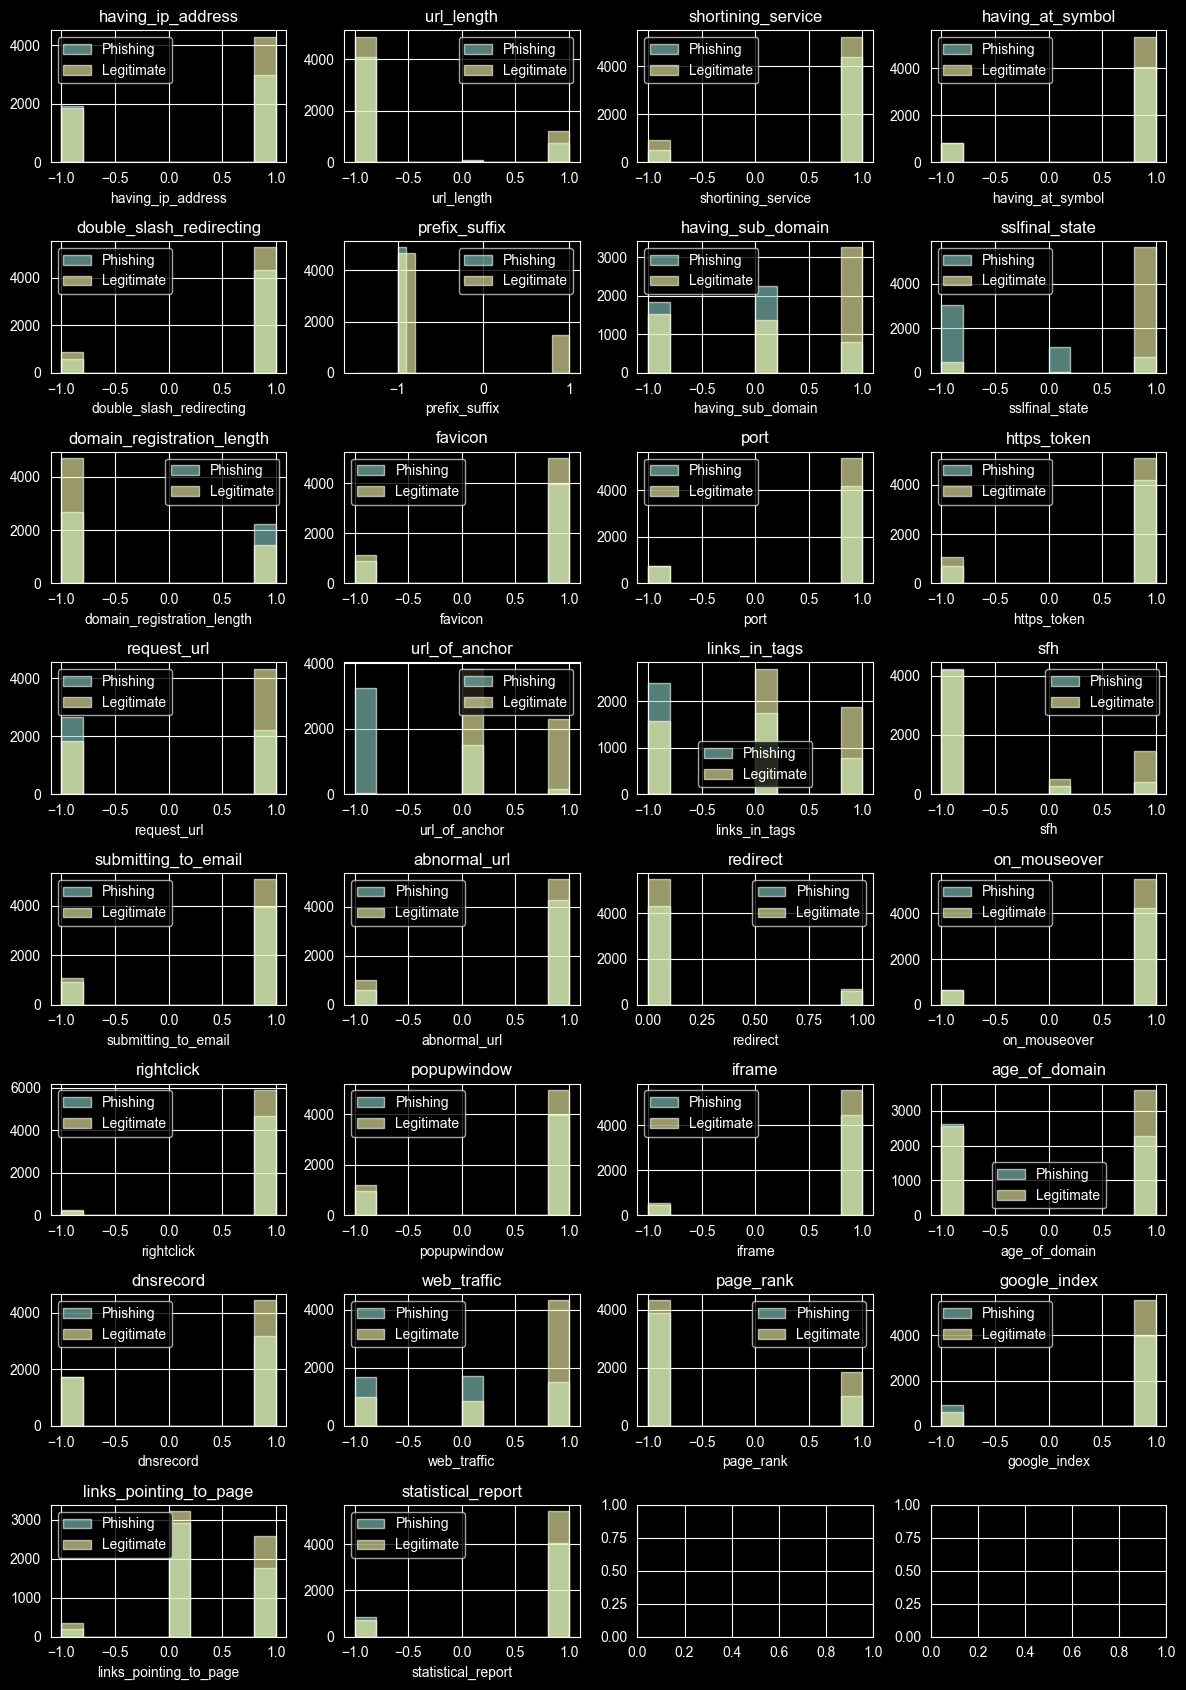

In [93]:
# Splitting the dataset to phishing and legitimate websites then for each feature we create a histogram where we layer the two classes on top of each other.
phishing_data = data[data['result'] == -1]
legitimate_date = data[data['result'] == 1]

phishing_data = phishing_data.drop(columns=['result'])
legitimate_date = legitimate_date.drop(columns=['result'])

# fig is for the whole figure, axes is for the individual subplots
fig, axes = plt.subplots(8, 4, figsize=(12, 17))
# axes.flatten() is used to convert the 2D array of axes into a 1D array for easier iteration
axes = axes.flatten()

# We know that both dataframes have the same columns, so we can use either for index and column names.
for i, column in enumerate(phishing_data.columns):
    ax = axes[i] # Temporary variable for the current subplot
    ax.hist(phishing_data[column], alpha=0.6, label='Phishing')
    ax.hist(legitimate_date[column], alpha=0.6, label='Legitimate')
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

From the visualization we can see that features like "sslfinal_state", "request_url", "url_of_anchor", and "web_traffic" show more distinct differences between phishing and legitimate websites. These features could be more informative for the classification task.


## Data Preparation

Since we already made the statement that the dataset does not contain any missing values and all features are cleaned, we can proceed to split the dataset into training and test sets.


In [94]:
random_state = 20
test_size = 0.2
max_depth = 2

X = data.drop(columns=['result'])  # input features
y = data['result']  # target feature

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)  # extract test set

legitimate_train = y_train[y_train == 1].shape[0]
phishing_train = y_train[y_train == -1].shape[0]
legitimate_test = y_test[y_test == 1].shape[0]
phishing_test = y_test[y_test == -1].shape[0]

print(f'Training set - Legitimate: {legitimate_train}, Phishing: {phishing_train}')
print(f'Test set - Legitimate: {legitimate_test}, Phishing: {phishing_test}')

Training set - Legitimate: 4918, Phishing: 3926
Test set - Legitimate: 1239, Phishing: 972


## Modeling

Now that the data has been splitted, next step is to choose an algorithms for our models.
Algorithms used:
- Decision tree
- Random forest tree


In [95]:
DecisionTreeModel = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
RandomForestModel = RandomForestClassifier(max_depth=5, n_estimators=100, bootstrap=True, max_samples=0.7, max_features=0.75, random_state=random_state,
                               oob_score=True)

Now we will train our models

In [96]:
DecisionTreeModel.fit(X_train, y_train)
RandomForestModel.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",0.75
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_tr

Now that the models are fitted we can first visualize the decision tree to understand how it classifies websites as phishing or legitimate based on the features.

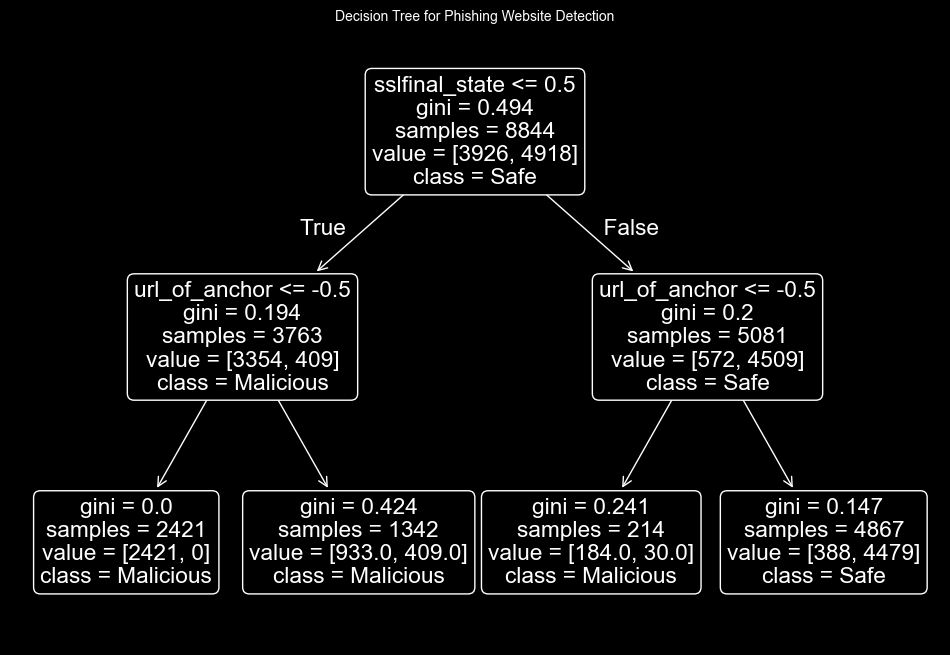

In [97]:
fig = plt.figure(figsize = (12, 8))
plot_tree(DecisionTreeModel, feature_names = X.keys(), class_names = ['Malicious', 'Safe'], rounded = True)

plt.title("Decision Tree for Phishing Website Detection", fontsize = 10)
plt.show()

Like we predicted in the data understanding section, the model uses features like "sslfinal_state" and "url_of_anchor" to make its decisions. The tree structure shows how the model splits the data based on feature values to classify websites. To go over the models decision making logic more in detail:
- The root node looks at the "sslfinal_state" feature. If the value is less than or equal to 0.5, it indicates that the site is likely a phishing site.
- - Next it checks the "url_of_anchor" feature. If this value is less than or equal to -0.5, it classifies the site as phishing site with high confidence. If the value is greater than -0.5, it still classifies it as phishing but with lower confidence.
- To go back to the root node, if the "sslfinal_state" value is greater than 0.5, it indicates that the site is likely legitimate and moves over to the right child node.
- - Here it again checks the "url_of_anchor" feature. If this value is less than or equal to -0.5, it classifies the site as a phishing site with fair confidence. If the value is greater than -0.5, it classifies the site as legitimate with higher, but not 100% confidence.

Next we can visualize one of the random forest trees to see how it differs from the decision tree model.

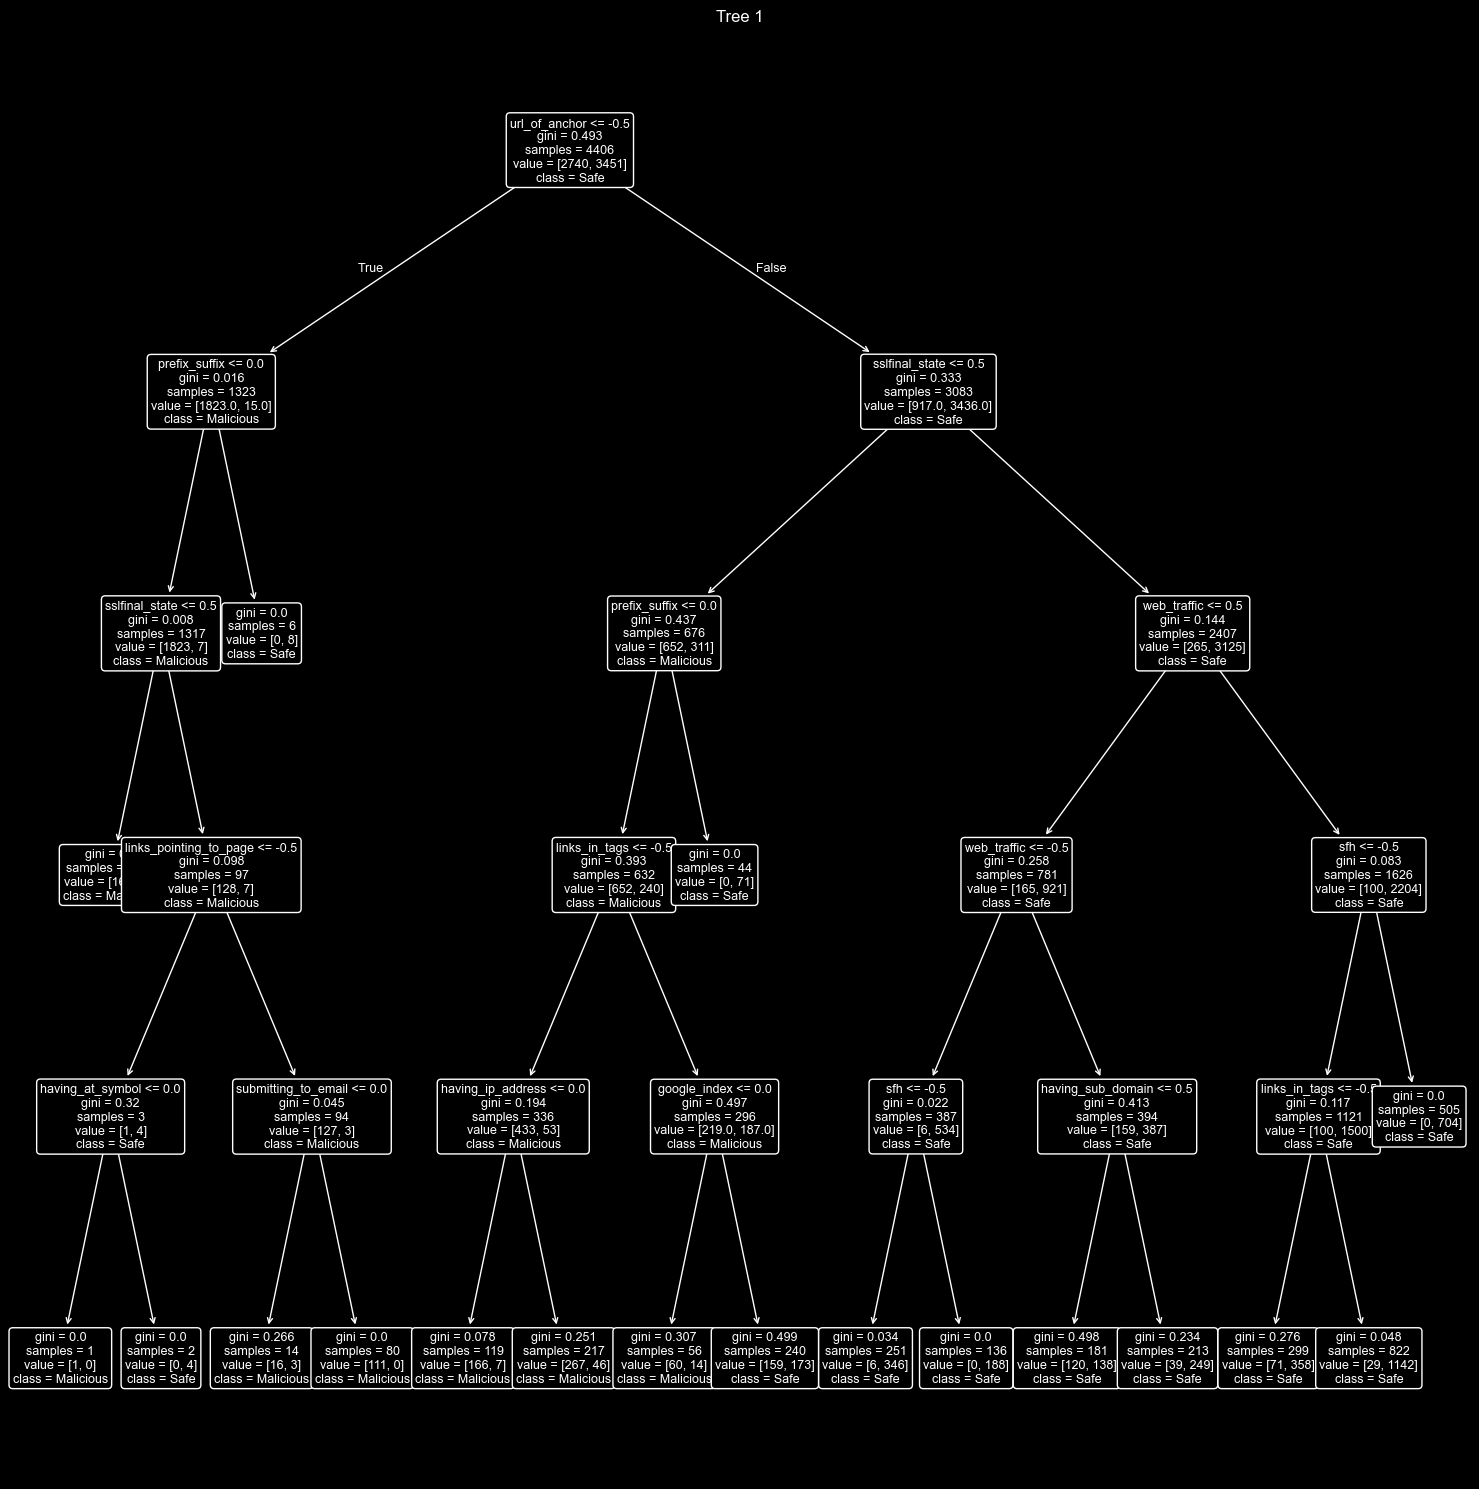

In [98]:
n_trees_to_plot = 1

plt.figure(figsize=(15, 15))

for i in range(n_trees_to_plot):
    plt.subplot(1, n_trees_to_plot, i + 1)  # Setting up subplots (1 row, n_trees_to_plot columns)
    plot_tree(
        RandomForestModel.estimators_[i],
        fontsize=9,
        feature_names=X.columns,
        class_names=['Malicious', 'Safe'],
        rounded=True
    )
    plt.title(f'Tree {i + 1}')

plt.tight_layout()
plt.show()

As we can see from the visualization, random forest trees use different features and splits compared to the decision tree. This diversity among the trees helps the random forest model to generalize better and reduce overfitting.

## Evaluation

Now we can evaluate the models by computing their accuracy and other classification metrics on the test set. We start the evaluation with the decision tree model and print the classification report.

In [99]:
# Compute test accuracy for Decision tree model
y_test_pred_decision = DecisionTreeModel.predict(X_test)

print("Test Metrics for Decision model:")
print(classification_report(y_test, y_test_pred_decision, target_names=['Malicious', 'Safe']))

Test Metrics for Decision model:
              precision    recall  f1-score   support

   Malicious       0.88      0.91      0.89       972
        Safe       0.93      0.90      0.91      1239

    accuracy                           0.91      2211
   macro avg       0.90      0.91      0.90      2211
weighted avg       0.91      0.91      0.91      2211



Now we do the same for Random Forest model.

In [100]:
# Compute test accuracy for Random Forest model
y_test_pred_forest = RandomForestModel.predict(X_test)

print("Test Metrics for Random Forest model:")
print(classification_report(y_test, y_test_pred_forest, target_names=['Malicious', 'Safe']))

Test Metrics for Random Forest model:
              precision    recall  f1-score   support

   Malicious       0.94      0.91      0.92       972
        Safe       0.93      0.95      0.94      1239

    accuracy                           0.93      2211
   macro avg       0.94      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211



Comparing the classification reports of both models, we can see that the random forest model generally outperforms the decision tree model in terms of accuracy, precision, recall, and F1-score. This is expected as random forests leverage the power of multiple trees to make more robust predictions.

We can also visualize the performance of the models using confusion matrices. Starting with the decision tree model:

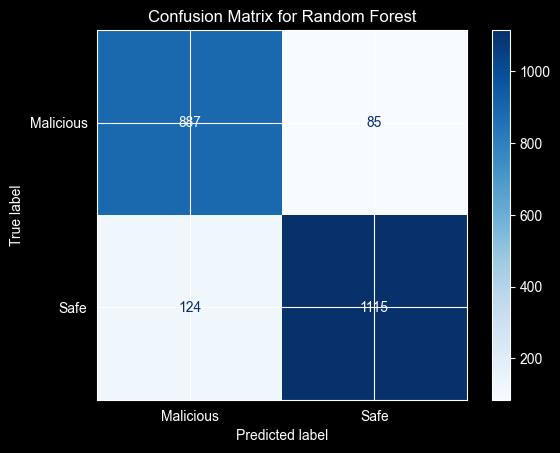

In [101]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_decision)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Malicious', 'Safe'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Decision Tree")

plt.show()

Then we create the confusion matrix for the random forest model:

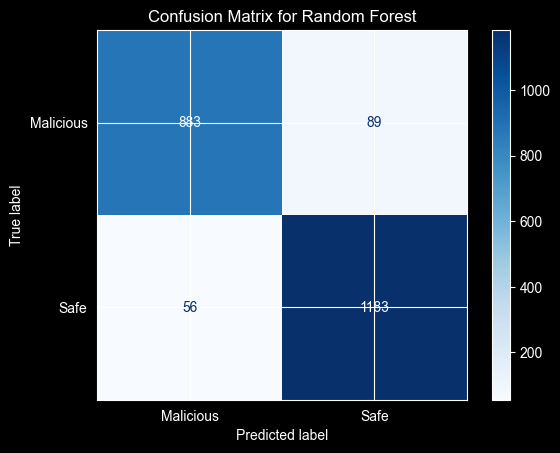

In [102]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_forest)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Malicious', 'Safe'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest")

plt.show()

From the confusion matrices, we can see that the random forest model has fewer misclassifications compared to the decision tree model, further highlighting its superior performance.

## Deployment

This model could be used on a website as a way to check if a given website is considered malicious or not (Like VirusTotal, but by taking parameters instead of using other security services to check) Program would output if the website is considered malicious or not and then explain why this is.

- Would showcase what attributes contribute to the site being malicious
- Incase there are enough "Malicious" aspects but the website is still categorised as safe, it could include these as a reminder that the website could still be malicious.

Due to the decision still being a prediction and not 100% accurate information, websites cannot be fully advertised as "Safe" or "Malicious" unless a more thorough security check is done.